In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict

In [ ]:
def parse_performance_log(log_file_path):
    """Parse the performance log and extract stream statistics."""
    stream_data = defaultdict(list)
    gpu_data = []
    
    with open(log_file_path, 'r') as f:
        lines = f.readlines()
    
    current_test_streams = None
    
    for line in lines:
        try:
            log_entry = json.loads(line.strip())
            
            # Extract number of streams from initialization messages
            if "Initialized" in log_entry.get("fields", {}).get("message", ""):
                match = re.search(r"Initialized (\d+) processors", log_entry["fields"]["message"])
                if match:
                    current_test_streams = int(match.group(1))
            
            # Extract inference statistics
            if log_entry.get("target") == "client::inference::source" and "inference statistics" in log_entry.get("fields", {}).get("message", ""):
                if current_test_streams is not None:
                    fields = log_entry["fields"]
                    stream_data[current_test_streams].append({
                        'avg_processing': fields.get('avg_processing', 0),
                        'total_success': fields.get('frames_success', 0),
                        'total_expected': fields.get('frames_expected', 0),
                        'total_failed': fields.get('frames_failed', 0)
                    })
            
            # Extract GPU utilization data
            if "GPU utilization information" in log_entry.get("fields", {}).get("message", ""):
                fields = log_entry["fields"]
                gpu_data.append({
                    'timestamp': log_entry["timestamp"],
                    'util_perc': fields.get('util_perc', 0),
                    'memory_perc': fields.get('memory_perc', 0),
                    'memory_used_mb': fields.get('memory_used_mb', 0),
                    'memory_total_mb': fields.get('memory_total_mb', 0),
                    'streams': current_test_streams
                })
                
        except (json.JSONDecodeError, KeyError):
            continue
    
    return stream_data, gpu_data


def calculate_stream_stats(stream_data, gpu_data):
    """Calculate aggregated statistics for each stream count."""
    results = []
    
    for num_streams in sorted(stream_data.keys()):
        # Calculate inference statistics - filter out zero avg_processing values
        valid_entries = [entry for entry in stream_data[num_streams] if entry['avg_processing'] > 0]
        processing_times = [entry['avg_processing'] for entry in valid_entries]
        success_counts = [entry['total_success'] for entry in valid_entries]
        expected_counts = [entry['total_expected'] for entry in valid_entries]
        failed_counts = [entry['total_failed'] for entry in valid_entries]
        
        if not processing_times:
            continue
            
        # Convert from microseconds to milliseconds
        avg_latency = np.mean(processing_times) / 1000
        p99_latency = np.percentile(processing_times, 99) / 1000
        min_latency = np.min(processing_times) / 1000
        max_latency = np.max(processing_times) / 1000
        
        # Calculate completion rates - handle cases where success > expected
        total_success = sum(success_counts)
        total_expected = sum(expected_counts)
        total_failed = sum(failed_counts)
        
        # Use the maximum of success+failed vs expected to avoid >100% rates
        total_processed = total_success + total_failed
        effective_expected = max(total_expected, total_processed)
        
        frame_completion_rate = (total_success / max(effective_expected, 1)) * 100 if effective_expected > 0 else 0
        frame_miss_rate = (total_failed / max(effective_expected, 1)) * 100 if effective_expected > 0 else 0
        
        # Calculate average frames completed per expected (capped at expected)
        avg_frames_completed = total_success / len(success_counts) if success_counts else 0
        avg_frames_expected = total_expected / len(expected_counts) if expected_counts else 0
        
        # Calculate GPU utilization for this stream count
        gpu_utils_for_streams = [entry['util_perc'] for entry in gpu_data if entry['streams'] == num_streams]
        gpu_memory_for_streams = [entry['memory_perc'] for entry in gpu_data if entry['streams'] == num_streams]
        avg_gpu_util = np.mean(gpu_utils_for_streams) if gpu_utils_for_streams else 0
        avg_gpu_memory = np.mean(gpu_memory_for_streams) if gpu_memory_for_streams else 0
        
        results.append({
            'num_streams': num_streams,
            'avg_latency_ms': avg_latency,
            'p99_latency_ms': p99_latency,
            'min_latency_ms': min_latency,
            'max_latency_ms': max_latency,
            'frame_completion_rate': frame_completion_rate,
            'frame_miss_rate': frame_miss_rate,
            'gpu_util_percent': avg_gpu_util,
            'gpu_memory_percent': avg_gpu_memory,
            'avg_frames_completed': avg_frames_completed,
            'avg_frames_expected': avg_frames_expected
        })
    
    return results


def plot_performance_analysis(log_file_path, efficiency_threshold=90, latency_cap_ms=34, gpu_util_cap=90):
    """Create performance analysis plot from log file."""
    
    # Parse the log file
    stream_data, gpu_data = parse_performance_log(log_file_path)
    
    if not stream_data:
        print("No stream data found in log file")
        return
    
    # Calculate statistics
    results = calculate_stream_stats(stream_data, gpu_data)
    
    if not results:
        print("No valid results calculated")
        return
    
    # Extract data for plotting
    x_streams = [r['num_streams'] for r in results]
    y_latency = [r['avg_latency_ms'] for r in results]
    gpu_utils = [r['gpu_util_percent'] for r in results]
    gpu_memory = [r['gpu_memory_percent'] for r in results]
    frame_completion = [r['frame_completion_rate'] for r in results]
    frame_miss = [r['frame_miss_rate'] for r in results]
    p99s = [r['p99_latency_ms'] for r in results]
    mins = [r['min_latency_ms'] for r in results]
    maxs = [r['max_latency_ms'] for r in results]
    avg_frames_completed = [r['avg_frames_completed'] for r in results]
    avg_frames_expected = [r['avg_frames_expected'] for r in results]
    
    # Normalize GPU utilization for color mapping
    norm_gpu_util = np.array(gpu_utils) / 100.0
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Create scatter plot with GPU utilization as color
    scatter = plt.scatter(
        x_streams, y_latency,
        c=norm_gpu_util,
        cmap='viridis',
        s=100,
        marker='o',
        edgecolor='k',
        alpha=0.85
    )
    
    # Find the best performance point
    best_idx = None
    max_streams = -1
    
    # First try to find point meeting all criteria
    for i, (streams, latency, frame_comp, gpu_util) in enumerate(zip(x_streams, y_latency, frame_completion, gpu_utils)):
        if (latency <= latency_cap_ms and 
            frame_comp >= efficiency_threshold and 
            gpu_util <= gpu_util_cap and 
            streams > max_streams):
            best_idx = i
            max_streams = streams
    
    # If no point meets all criteria, find best latency point under cap
    if best_idx is None:
        for i, (streams, latency) in enumerate(zip(x_streams, y_latency)):
            if latency <= latency_cap_ms and streams > max_streams:
                best_idx = i
                max_streams = streams
    
    # Add annotation for best point
    if best_idx is not None:
        x = x_streams[best_idx]
        y = y_latency[best_idx]
        label_text = (
            r"$\bf{Best\ Performance\ Point}$:"
            f"\nStreams: {x}\n"
            f"Avg Latency: {y_latency[best_idx]:.1f}ms\n"
            f"P99 Latency: {p99s[best_idx]:.1f}ms\n"
            f"Min Latency: {mins[best_idx]:.1f}ms\n"
            f"Max Latency: {maxs[best_idx]:.1f}ms\n"
            f"Frame Completion: {frame_completion[best_idx]:.1f}%\n"
            f"Frames Completed: {avg_frames_completed[best_idx]:.0f}/{avg_frames_expected[best_idx]:.0f} (avg)\n"
            f"Frame Miss Rate: {frame_miss[best_idx]:.1f}%\n"
            f"GPU Util: {gpu_utils[best_idx]:.1f}%\n"
            f"GPU Memory: {gpu_memory[best_idx]:.1f}%"
        )
        # Highlight the best point with annotation
        plt.annotate(
            label_text,
            (x, y),
            textcoords="offset points",
            xytext=(-160, 50),
            ha='left',
            va='bottom',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3")
        )
    
    # Add latency threshold line
    plt.axhline(latency_cap_ms, color='red', linestyle='--', linewidth=2, 
                label=f'Latency Cap: {latency_cap_ms}ms')
    
    # Customize the plot
    plt.xlabel(f"Concurrent Streams", fontsize=10)
    plt.ylabel("Average Latency (ms)", fontsize=10)
    plt.title("Performance Analysis: Latency vs Concurrent Streams\n(Inference Processing Time)", fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label("GPU Utilization (%)", fontsize=10)
    cbar.ax.yaxis.set_tick_params(labelsize=10)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\nPerformance Summary:")
    print(f"{'Streams':<8} {'Avg Latency':<12} {'GPU Util':<10} {'GPU Memory':<12} {'Completion':<12}")
    print("-" * 60)
    for r in results:
        print(f"{r['num_streams']:<8} {r['avg_latency_ms']:<12.1f} {r['gpu_util_percent']:<10.1f} {r['gpu_memory_percent']:<12.1f} {r['frame_completion_rate']:<12.1f}")
    
    plt.show()


Performance Summary:
Streams  Avg Latency  GPU Util   GPU Memory   Completion  
------------------------------------------------------------
5        13.5         25.8       17.1         0.0         
10       14.5         34.9       22.9         0.0         
15       15.9         63.0       28.0         0.0         
20       17.8         61.7       28.3         0.0         
25       19.3         64.5       34.0         0.0         
30       20.7         61.6       39.0         0.0         
35       21.0         57.5       39.0         0.0         
40       21.8         15.4       45.0         0.0         
45       23.4         50.7       50.0         0.0         
50       24.1         79.7       48.1         0.0         
55       24.8         90.3       56.0         0.0         
60       25.6         15.8       62.0         0.0         


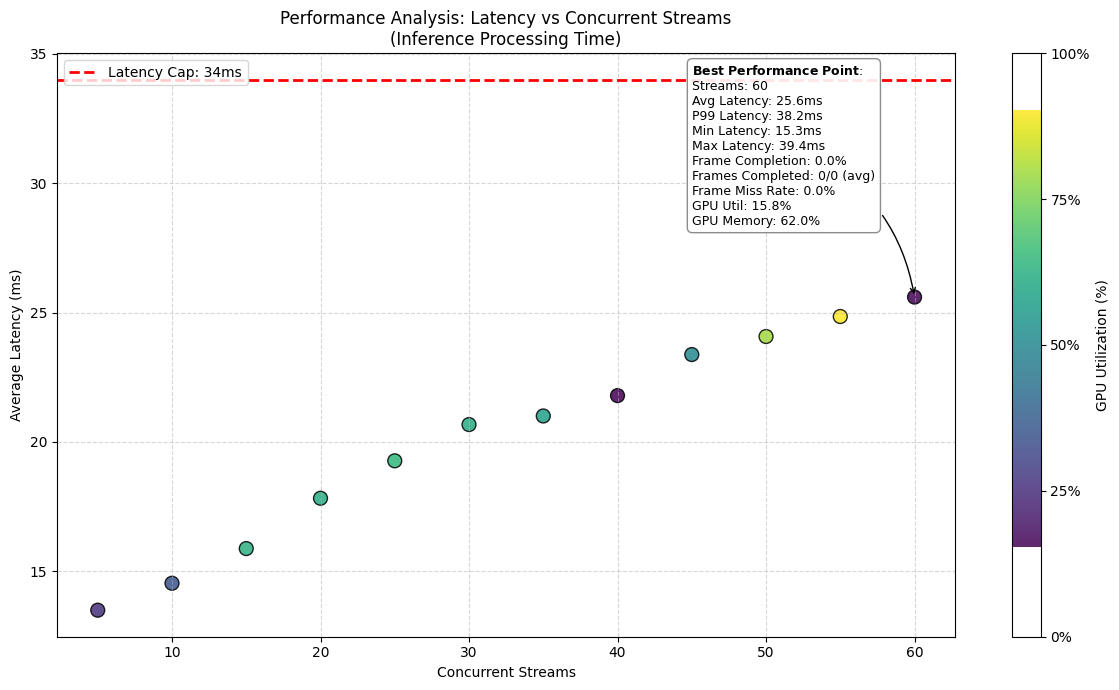

In [3]:
# Replace with your log file path
log_file_path = "/mnt/disk_e/Programming/real-time-object-detection/client-triton/client/logs/app.log"

plot_performance_analysis(
    log_file_path=log_file_path,
    latency_cap_ms=34,

    # Thresholds for best point calculation
    efficiency_threshold=90,
    gpu_util_cap=90
)